## Linear Time Series

Univariate Time Series(단변량 시계열)은 동일한 간격의 시간의 증가에 대해 순차적으로 기록된 한개의 변수로 구성된 시계열을 지칭한다.

In [1]:
import yfinance as yf

START_DATE = '2015-01-01'

data = yf.download(
    '^GSPC', 
    start = START_DATE, 
    progress = False
)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [2]:
week_close = data['Close'].resample('W-FRI').last()
ret = week_close.pct_change().dropna()

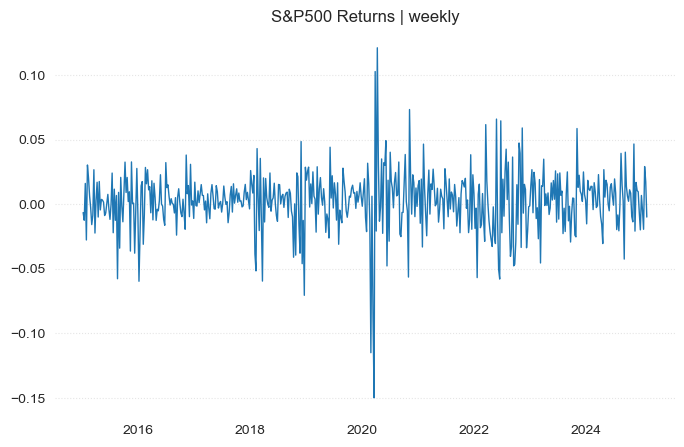

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(ret, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'S&P500 Returns | weekly')
plt.show()

### 1. AR Model

예측력이 있는 가장 간단한 $\mathrm{AR}$ 모형은 다음과 같다
$$r_t = \phi_0 + \phi_1 r_{t-1} + a_t$$
여기에서  ${a_t}$ 는 평균이 0이고 분산이 $σ_a^2$인 white noise series이다. 즉, 오차항은 정규분포를 이룬다

여기서 $\mathrm{AR(1)}$ 모형은 과거 수익률 $r_{t−1}$을 조건으로 하는 조건부 모형을 의미한다고 볼 수 있다. 여기에서 우리는 다음과 같은 모형을 얻을 수 있다

$$E(r_t|r_{t-1}) = \phi_0 + \phi_1 r_{t-1}, ~~~~~ \mathrm{Var}(r_t|r_{t-1}) = \mathrm{Var}(a_t) = \sigma_a^2$$

간단한 $\mathrm{AR(1)}$모형의 일반화된 모형은 $\mathrm{AR(p)}$ 모형으로, 다음과 같이 표현할 수 있다

$$r_t = \phi_0 + \phi_1 r_{t-1} + \cdots + \phi_p r_{t-p} + a_t$$

#### AR 차수 구하기

AR 모형의 차수는 PACF 함수의 단절된 면을 보고 구할 수 있다.

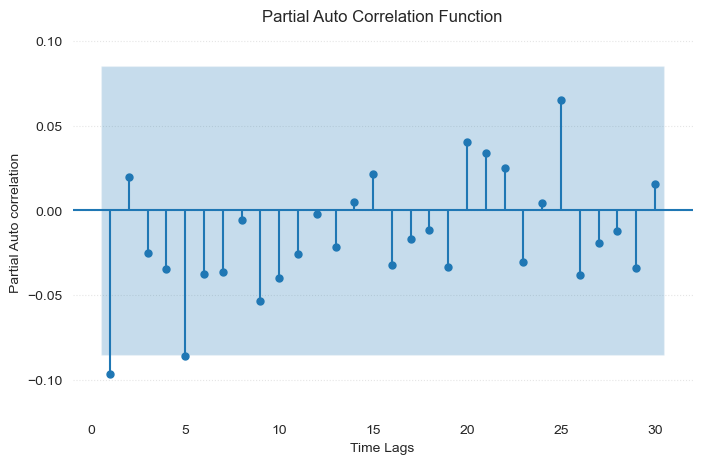

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    ret, 
    auto_ylims = True, 
    lags = range(1, 31), 
    method = 'ywm',
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.ylabel('Partial Auto correlation')
plt.xlabel('Time Lags')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Auto Correlation Function')
plt.show()

#### Model Fitting

In [12]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

ar_model = sm.tsa.ARIMA(
    ret, 
    order = (1, 0, 0), # (AR, I, MA)
    trend = 'c'
).fit(method = 'innovations_mle')
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  526
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1234.670
Date:                Sat, 01 Feb 2025   AIC                          -2463.340
Time:                        19:07:19   BIC                          -2450.544
Sample:                    01-09-2015   HQIC                         -2458.330
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.232      0.026       0.000       0.004
ar.L1         -0.0965      0.025     -3.800      0.000      -0.146      -0.047
sigma2         0.0005   1.64e-05     32.559      0.0

예측값은 `forecast()` method를 사용해 다음 기의 예측치를 출력할 수 있다.

In [13]:
ar_model.forecast().values[0] # predicted value

0.0035103556424259767

잔차를 구하려면 `resid` 속성을 이용해 구할 수 있다. 실제값 - fitting된 값의 차로 계산한다.

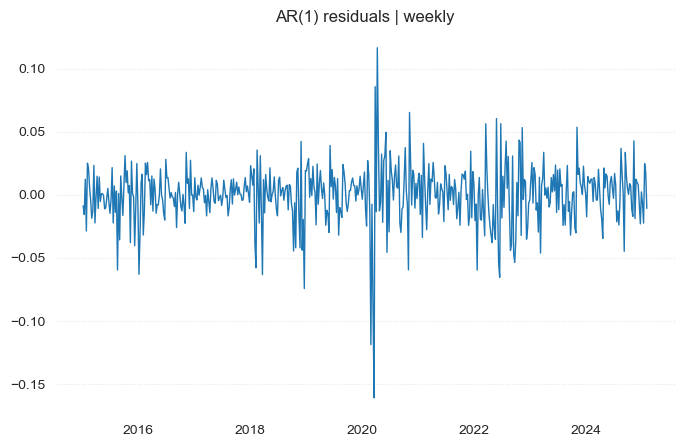

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(ar_model.resid, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'AR(1) residuals | weekly')
plt.show()

#### 1-step ahead prediction

In [17]:
from tqdm import tqdm

WINDOW = 60 # 60기간의 데이터를 train data로 설정
y_pred = []

for period in tqdm(range(60, len(ret))) :
    ar_model = sm.tsa.ARIMA(
        ret[period - WINDOW : period],
        order = (1, 0, 0), 
        trend = 'c'
    ).fit(method = 'innovations_mle')
    predicted = ar_model.forecast().values[0] # 그 다음날의 값
    y_pred.append(predicted)

100%|██████████| 466/466 [00:14<00:00, 32.63it/s]


In [18]:
import pandas as pd

y_pred_ar = pd.Series(
    y_pred,
    index = ret.index[60:]
) # AR(1) 모형의 1step ahead prediction

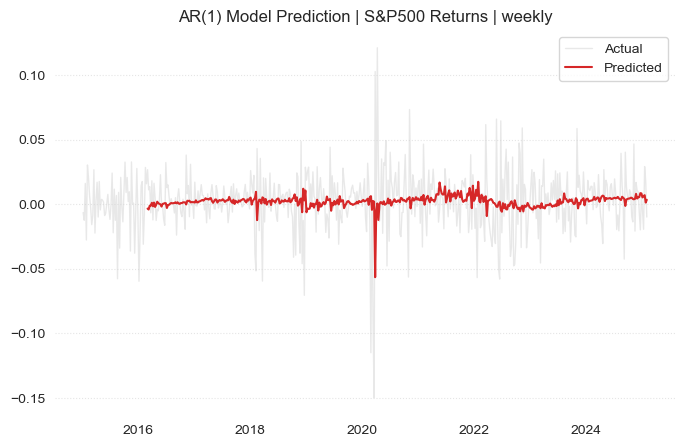

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(ret, lw = 1, label = 'Actual', alpha = 0.5, c = 'lightgray')
ax.plot(y_pred_ar, label = 'Predicted', c = 'tab:red')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'AR(1) Model Prediction | S&P500 Returns | weekly')
plt.show()

대표적인 평가 지표인 MSE (mean squared error)는 다음과 같이 구한다. 0에 가까울 수록 모델의 예측 능력이 더 뛰어난 것을 의미한다.

In [20]:
ar_square_error = ((ret - y_pred_ar)**2).mean()

In [21]:
ar_square_error

0.0006132524756961587

### 2. MA models

이동평균모형 $\mathrm{MA(1)}$ 모델의 일반적인 형태는 다음과 같다

$$r_t = c_0 + a_t - \theta_1 a_{t-1}~~~\mathrm{or}~~~r_t = c_0 + (1-\theta_1 B)a_t$$

마찬가지로 $\mathrm{MA(1)}$모형의 일반화된 $\mathrm{MA(q)}$ 모델은 다음과 같다

$$r_t = c_0 + a_t - \theta_1 a_{t-1} - \cdots - \theta_qa_{t-q}$$

#### MA 차수 구하기

MA 차수는 ACF의 단절된 점을 기준으로 구할 수 있다.

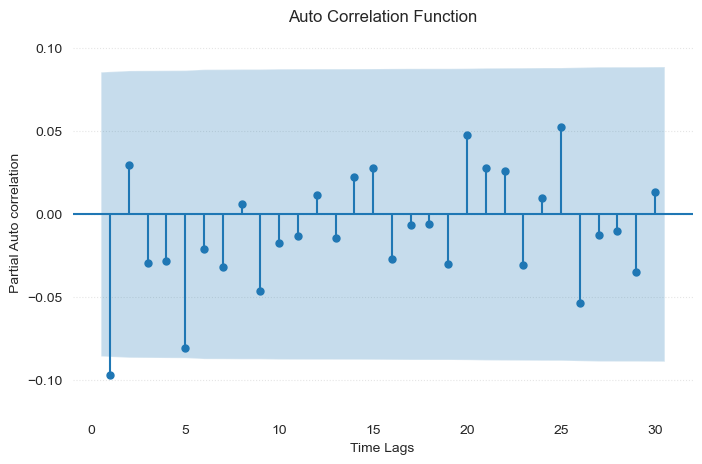

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    ret.dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.ylabel('Partial Auto correlation')
plt.xlabel('Time Lags')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Auto Correlation Function')
plt.show()

#### Model Fitting

In [23]:
ma_model = sm.tsa.ARIMA(
    ret, 
    order = (0, 0, 1), # (AR, I, MA)
    trend = 'c'
).fit(method = 'innovations_mle')
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  526
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1234.567
Date:                Sat, 01 Feb 2025   AIC                          -2463.135
Time:                        19:10:04   BIC                          -2450.339
Sample:                    01-09-2015   HQIC                         -2458.125
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.245      0.025       0.000       0.004
ma.L1         -0.0928      0.025     -3.780      0.000      -0.141      -0.045
sigma2         0.0005   1.65e-05     32.437      0.0

In [24]:
ma_model.forecast().values[0] # predicted value

0.003315169116486234

#### 1-step ahead prediction

In [25]:
WINDOW = 60 # 60기간의 데이터를 train data로 설정
y_pred = []

for period in tqdm(range(60, len(ret))) :
    ma_model = sm.tsa.ARIMA(
        ret[period - WINDOW : period],
        order = (0, 0, 1), 
        trend = 'c'
    ).fit(method = 'innovations_mle')
    predicted = ma_model.forecast().values[0] # 그 다음날의 값
    y_pred.append(predicted)

100%|██████████| 466/466 [00:25<00:00, 17.95it/s]


In [26]:
y_pred_ma = pd.Series(
    y_pred,
    index = ret.index[60:]
)

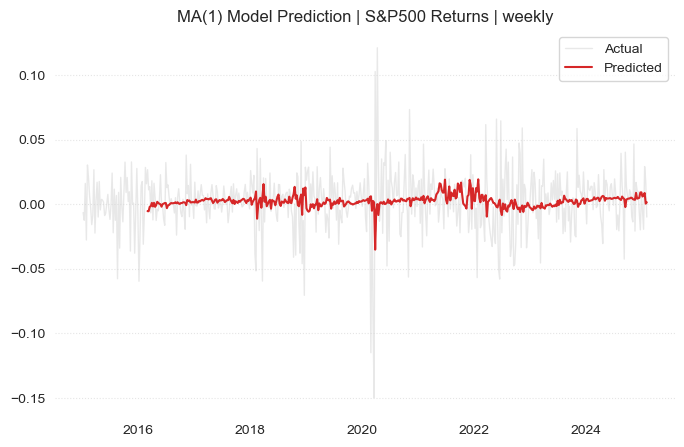

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(ret, lw = 1, label = 'Actual', alpha = 0.5, c = 'lightgray')
ax.plot(y_pred_ma, label = 'Predicted', c = 'tab:red')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'MA(1) Model Prediction | S&P500 Returns | weekly')
plt.show()

In [28]:
ma_square_error = ((ret - y_pred_ma)**2).mean()

In [29]:
ma_square_error

0.0006029968103721141

### 3. ARMA models

시계열 $r_t$은 다음을 만족하는 경우 $\mathrm{ARMA(1,1)}$ 모델을 따른다

$$r_t = \phi_0 + \phi_1 r_{t-1} + a_t - \theta_1 a_{t-1}$$

마찬가지로 $\mbox{ARMA(1)}$모형이 일반화된 $\mathrm{ARMA}(p,q)$ 모델은 다음과 같다

$$r_t = \phi_0 + \sum_{i=1}^p \phi_i r_{t-i} + a_t - \sum_{i=1}^q \theta_i a_{t-i}$$

#### ARMA 차수 구하기

AR모형과 MA모형의 차수를 추정할 때, 각각 p=1, q=1이 도출되었으므로 ARMA(1,1) 모형을 사용하도록 한다.

#### Model Fitting

In [30]:
arma_model = sm.tsa.ARIMA(
    ret, 
    order = (1, 0, 1), # (AR, I, MA)
    trend = 'c'
).fit(method = 'innovations_mle')
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  526
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1234.832
Date:                Sat, 01 Feb 2025   AIC                          -2461.664
Time:                        19:10:50   BIC                          -2444.602
Sample:                    01-09-2015   HQIC                         -2454.983
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.176      0.030       0.000       0.004
ar.L1         -0.3869      0.200     -1.931      0.053      -0.780       0.006
ma.L1          0.2946      0.209      1.408      0.1

In [31]:
arma_model.forecast().values[0] # predicted value

0.003609067678195932

#### 1-step ahead prediction

In [32]:
WINDOW = 60 # 60기간의 데이터를 train data로 설정
y_pred = []

for period in tqdm(range(60, len(ret))) :
    arma_model = sm.tsa.ARIMA(
        ret[period - WINDOW : period],
        order = (1, 0, 1), 
        trend = 'c'
    ).fit(method = 'innovations_mle')
    predicted = arma_model.forecast().values[0] # 그 다음날의 값
    y_pred.append(predicted)

100%|██████████| 466/466 [00:56<00:00,  8.27it/s]


In [33]:
y_pred_arma = pd.Series(
    y_pred,
    index = ret.index[60:]
)

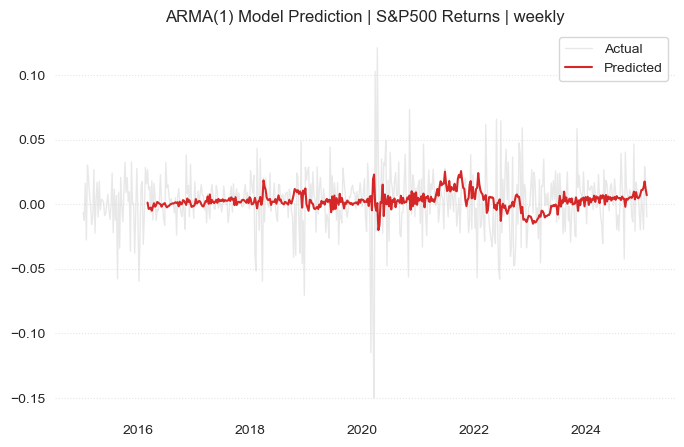

In [34]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(ret, lw = 1, label = 'Actual', alpha = 0.5, c = 'lightgray')
ax.plot(y_pred_arma, label = 'Predicted', c = 'tab:red')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'ARMA(1) Model Prediction | S&P500 Returns | weekly')
plt.show()

In [36]:
arma_square_error = ((ret - y_pred_arma)**2).mean()

In [38]:
arma_square_error

0.0006255721886840021

### Model Comparison

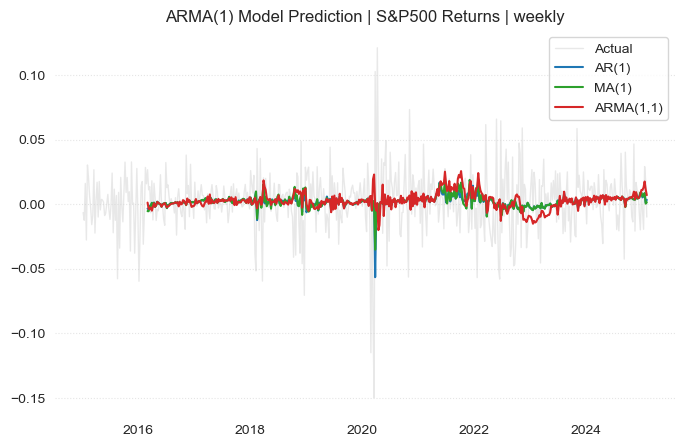

In [47]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(ret, lw = 1, label = 'Actual', alpha = 0.5, c = 'lightgray')
ax.plot(y_pred_ar, label = 'AR(1)', c = 'tab:blue')
ax.plot(y_pred_ma, label = 'MA(1)', c = 'tab:green')
ax.plot(y_pred_arma, label = 'ARMA(1,1)', c = 'tab:red')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'ARMA(1) Model Prediction | S&P500 Returns | weekly')
plt.show()

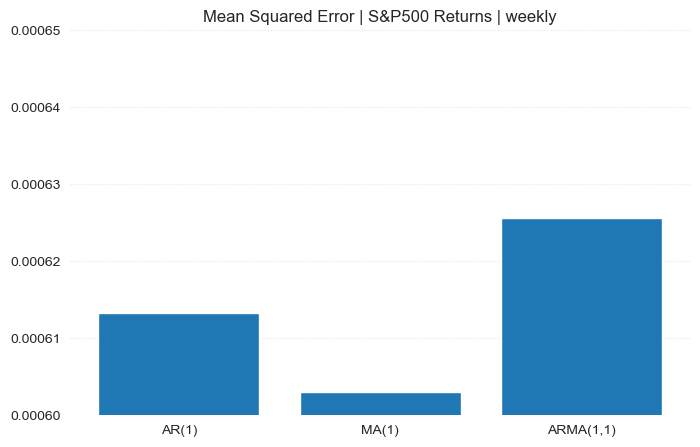

In [48]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.bar(
    ['AR(1)','MA(1)','ARMA(1,1)'],
    [ar_square_error, ma_square_error, arma_square_error]
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.ylim([0.0006, 0.00065])
plt.title(r'Mean Squared Error | S&P500 Returns | weekly')
plt.show()